# Introduction

This Notebook focuses on the classification of credit scores. In this notebook, we will explore and implement a machine learning model to categorize credit scores based on various features. By leveraging powerful algorithms, we aim to create an efficient and accurate system for predicting creditworthiness. 

# Methodology

For this particular notebook, we are going to first impute our class column which is Credit_Mix. Credit Mix has four unique values, which are: Good, Standard, Bad and ' _ '. We are going to handle the ' _ ' values as they don't represent anything. They basically mean nan values. So, we are going to impute these ' _ ' values. But rather than using traditional imputing methods, we are going to drop the rows which have their class values as ' _ ' and keep them in a separate dataframe. Then we are going to work on the remaining rows, preprocess them and fit them into models. Then we are going to use our models to predict the class values of our previously saved dataframe which contains '_' values as their class. After predicting them, we are going to merge these two dataframes into one. The we are going to work on the cleaned dataset, train-test them in different models and evaluate them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

# Initial Observations

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/main/Bank%20Data.csv")

In [3]:
data.head(5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [4]:
df = data.copy()

In [5]:
df["Credit_Mix"].unique()

array(['Good', '_', 'Standard', 'Bad'], dtype=object)

In [6]:
df.shape

(50000, 27)

### From our initial obseravation, we can say:
    - We have 27 columns in our dataset
    - Credit_Mix is our class column
    - We need to modify some columns to convert them into numeric values. e.g: Credit History Age

# Data Preparation & Preprocessing

## Remove Unnecessary Features

In [7]:
# We remove some columns from our dataset which aren't having any significant impact to our class column

In [8]:
df.drop(["ID","Customer_ID","Month","Name","SSN","Age","Occupation"],axis = 1,inplace = True)

In [9]:
df.isna().sum()

Annual_Income                  0
Monthly_Inhand_Salary       7498
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                5704
Delay_from_due_date            0
Num_of_Delayed_Payment      3498
Changed_Credit_Limit           0
Num_Credit_Inquiries        1035
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          4470
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     2271
Payment_Behaviour              0
Monthly_Balance              562
dtype: int64

In [10]:
df.dtypes

Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
dtype: object

In [11]:
def impute_dataset(df):
    for col_name in df.columns:
        if df[col_name].isna().sum() > 0 and df[col_name].nunique() > 5 and df[col_name].dtypes != "object":
            df[col_name].fillna(df[col_name].mean(),inplace = True)
        elif df[col_name].isna().sum() > 0 and df[col_name].nunique() < 5 and df[col_name].dtypes != "object":
            df[col_name].fillna(df[col_name].mode().iloc[0],inplace = True)

## Handle Type of Loan

*We need to modify our Type_of_Loan column as it has multiple loan types comma separated in a single string. To handle this, We are going to split our Type of loan column where there is an comma and we are going to remove 'and' from each row. We also going to handle any NAN value if there's any present in our column. Lastly we are going to use one-hot encoding.*

In [12]:
# df["Type_of_Loan"].unique()

In [13]:
# df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: list(set(item.replace(" and ", "").strip() for item in str(x).split(','))))
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: ', '.join(set(item.replace(" and ", "").strip() for item in str(x).split(','))))

    

In [14]:
df['Type_of_Loan']

0        Home Equity Loan, Credit-Builder Loan, Persona...
1        Home Equity Loan, Credit-Builder Loan, Persona...
2        Home Equity Loan, Credit-Builder Loan, Persona...
3        Home Equity Loan, Credit-Builder Loan, Persona...
4                                      Credit-Builder Loan
                               ...                        
49995    Personal Loan, Mortgage Loan, Student Loan, Au...
49996                              Student Loan, Auto Loan
49997                              Student Loan, Auto Loan
49998                              Student Loan, Auto Loan
49999                              Student Loan, Auto Loan
Name: Type_of_Loan, Length: 50000, dtype: object

In [15]:
unique_values_set = set()

for value in df["Type_of_Loan"]:
    value_list = [item.replace(" and ","").strip() for item in str(value).split(",") if item.strip() not in unique_values_set]
    unique_values_set.update(value_list)

unique_values = list(unique_values_set)

In [16]:
print(unique_values_set)

{'Payday Loan', 'Debt Consolidation Loan', 'Auto Loan', 'Home Equity Loan', 'nan', 'Credit-Builder Loan', 'Personal Loan', 'Mortgage Loan', 'Not Specified', 'Student Loan'}


In [17]:
df['Type_of_Loan'] = df['Type_of_Loan'].str.replace('and','')

In [18]:
df['Type_of_Loan'] = df['Type_of_Loan'].str.strip('')

In [19]:
df['Type_of_Loan'][0]

'Home Equity Loan, Credit-Builder Loan, Personal Loan, Auto Loan'

In [20]:
dummies = df['Type_of_Loan'].str.get_dummies(", ")

In [21]:
df = pd.concat([df, dummies], axis = 1)

In [22]:
df.shape

(50000, 30)

In [23]:
df.drop("Type_of_Loan",axis=1,inplace = True)

In [24]:
df.shape

(50000, 29)

In [25]:
df.nunique()

Annual_Income               16121
Monthly_Inhand_Salary       12793
Num_Bank_Accounts             540
Num_Credit_Card               819
Interest_Rate                 945
Num_of_Loan                   263
Delay_from_due_date            73
Num_of_Delayed_Payment        443
Changed_Credit_Limit         3927
Num_Credit_Inquiries          750
Credit_Mix                      4
Outstanding_Debt            12685
Credit_Utilization_Ratio    50000
Credit_History_Age            399
Payment_of_Min_Amount           3
Total_EMI_per_month         13144
Amount_invested_monthly     45450
Payment_Behaviour               7
Monthly_Balance             49433
Auto Loan                       2
Credit-Builder Loan             2
Debt Consolidation Loan         2
Home Equity Loan                2
Mortgage Loan                   2
Not Specified                   2
Payday Loan                     2
Personal Loan                   2
Student Loan                    2
nan                             2
dtype: int64

*We are dropping the nan column as we don't need it.If The other columns representing different loan types is zero '0', then we will automatically know if the user has any kind of loan or not.*

In [26]:
df.drop("nan",axis=1,inplace=True)

In [27]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
count,42502.000000,50000.000000,50000.000000,50000.000000,50000.000000,48965.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,4182.004291,16.838260,22.921480,68.772640,21.052640,30.080200,32.279581,1491.304305,0.305600,0.317280,0.310400,0.314000,0.31360,0.316800,0.319440,0.311040,0.310400
std,3174.109304,116.396848,129.314804,451.602363,14.860397,196.984121,5.106238,8595.647887,0.460666,0.465422,0.462662,0.464121,0.46396,0.465233,0.466264,0.462924,0.462662
min,303.645417,-1.000000,0.000000,1.000000,-5.000000,0.000000,20.509652,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1625.188333,3.000000,4.000000,8.000000,10.000000,4.000000,28.061040,32.222388,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3086.305000,6.000000,5.000000,13.000000,18.000000,7.000000,32.280390,74.733349,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,5934.189094,7.000000,7.000000,20.000000,28.000000,10.000000,36.468591,176.157491,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
max,15204.633333,1798.000000,1499.000000,5799.000000,67.000000,2593.000000,48.540663,82398.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Annual_Income             50000 non-null  object 
 1   Monthly_Inhand_Salary     42502 non-null  float64
 2   Num_Bank_Accounts         50000 non-null  int64  
 3   Num_Credit_Card           50000 non-null  int64  
 4   Interest_Rate             50000 non-null  int64  
 5   Num_of_Loan               50000 non-null  object 
 6   Delay_from_due_date       50000 non-null  int64  
 7   Num_of_Delayed_Payment    46502 non-null  object 
 8   Changed_Credit_Limit      50000 non-null  object 
 9   Num_Credit_Inquiries      48965 non-null  float64
 10  Credit_Mix                50000 non-null  object 
 11  Outstanding_Debt          50000 non-null  object 
 12  Credit_Utilization_Ratio  50000 non-null  float64
 13  Credit_History_Age        45530 non-null  object 
 14  Paymen

In [29]:
df["Credit_Mix"].isna().sum()

0

In [30]:
df["Payment_Behaviour"].nunique()

7

In [31]:
df.head(5)

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,19114.12,1824.843333,3,4,3,4,3,7,11.27,2022.0,...,186.26670208571772,1,1,0,1,0,0,0,1,0
1,19114.12,1824.843333,3,4,3,4,3,9,13.27,4.0,...,361.44400385378196,1,1,0,1,0,0,0,1,0
2,19114.12,1824.843333,3,4,3,4,-1,4,12.27,4.0,...,264.67544623342997,1,1,0,1,0,0,0,1,0
3,19114.12,NaN,3,4,3,4,4,5,11.27,4.0,...,343.82687322383634,1,1,0,1,0,0,0,1,0
4,34847.84,3037.986667,2,4,6,1,3,1,5.42,5.0,...,485.2984336755923,0,1,0,0,0,0,0,0,0


## Handle Credit History Age

*Our credit history age has values like 'X Years and Y Months'. We are going to transform this column into numerical values by converting the month value of each row to year and add it up to the total years. For example, 22 Years and 9 months-> 22 Years + 0.75 Years -> 22.75 Years*

In [32]:
for item in df["Credit_History_Age"].head(5):
    print(item)

22 Years and 9 Months
22 Years and 10 Months
nan
23 Years and 0 Months
27 Years and 3 Months


In [33]:
df["Credit_History_Age"] = df["Credit_History_Age"].apply(lambda x: float(x.split()[0]) + (float(x.split()[3])/12) if pd.notna(x) else x)

# df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: ', '.join(set(item.replace(" and ", "").strip() for item in str(x).split(','))))

In [34]:
df.head(5)

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,19114.12,1824.843333,3,4,3,4,3,7,11.27,2022.0,...,186.26670208571772,1,1,0,1,0,0,0,1,0
1,19114.12,1824.843333,3,4,3,4,3,9,13.27,4.0,...,361.44400385378196,1,1,0,1,0,0,0,1,0
2,19114.12,1824.843333,3,4,3,4,-1,4,12.27,4.0,...,264.67544623342997,1,1,0,1,0,0,0,1,0
3,19114.12,NaN,3,4,3,4,4,5,11.27,4.0,...,343.82687322383634,1,1,0,1,0,0,0,1,0
4,34847.84,3037.986667,2,4,6,1,3,1,5.42,5.0,...,485.2984336755923,0,1,0,0,0,0,0,0,0


In [35]:
df["Credit_History_Age"]

0        22.750000
1        22.833333
2              NaN
3        23.000000
4        27.250000
           ...    
49995          NaN
49996    31.916667
49997    32.000000
49998    32.083333
49999    32.166667
Name: Credit_History_Age, Length: 50000, dtype: float64

In [36]:
df.dtypes

Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Auto Loan                     int64
Credit-Builder Loan           int64
Debt Consolidation Loan       int64
Home Equity Loan              int64
Mortgage Loan                 int64
Not Specified                 int64
Payday Loan                   int64
Personal Loan                 int64
Student Loan                

## Encoding Data

In [37]:
# Payment Behaviour, Payment of Min Amount
from sklearn.preprocessing import LabelEncoder

In [38]:
encoder = LabelEncoder()

In [39]:
def encode_dataset(df):
    for col_name in df.columns:
        if df[col_name].dtypes == "object":
            df[col_name] = encoder.fit_transform(df[col_name])

In [40]:
df["Payment_Behaviour"] = encoder.fit_transform(df["Payment_Behaviour"])

In [41]:
df["Payment_of_Min_Amount"] = encoder.fit_transform(df["Payment_of_Min_Amount"])

In [42]:
df.dtypes

Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount         int64
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour             int64
Monthly_Balance              object
Auto Loan                     int64
Credit-Builder Loan           int64
Debt Consolidation Loan       int64
Home Equity Loan              int64
Mortgage Loan                 int64
Not Specified                 int64
Payday Loan                   int64
Personal Loan                 int64
Student Loan                

In [43]:
df.nunique()

Annual_Income               16121
Monthly_Inhand_Salary       12793
Num_Bank_Accounts             540
Num_Credit_Card               819
Interest_Rate                 945
Num_of_Loan                   263
Delay_from_due_date            73
Num_of_Delayed_Payment        443
Changed_Credit_Limit         3927
Num_Credit_Inquiries          750
Credit_Mix                      4
Outstanding_Debt            12685
Credit_Utilization_Ratio    50000
Credit_History_Age            399
Payment_of_Min_Amount           3
Total_EMI_per_month         13144
Amount_invested_monthly     45450
Payment_Behaviour               7
Monthly_Balance             49433
Auto Loan                       2
Credit-Builder Loan             2
Debt Consolidation Loan         2
Home Equity Loan                2
Mortgage Loan                   2
Not Specified                   2
Payday Loan                     2
Personal Loan                   2
Student Loan                    2
dtype: int64

In [44]:
df["Num_of_Delayed_Payment"]

0          7
1          9
2          4
3          5
4          1
        ... 
49995     25
49996    NaN
49997      5
49998     6_
49999      5
Name: Num_of_Delayed_Payment, Length: 50000, dtype: object

In [45]:
df.dtypes

Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount         int64
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour             int64
Monthly_Balance              object
Auto Loan                     int64
Credit-Builder Loan           int64
Debt Consolidation Loan       int64
Home Equity Loan              int64
Mortgage Loan                 int64
Not Specified                 int64
Payday Loan                   int64
Personal Loan                 int64
Student Loan                

## Data Cleaning & Type Conversion

*In this subsection, we are going to iterate through each of the column and clean the values where it's need. e.g: Underscores '_'. We are also going to convert data types where it's needed*

In [46]:
for col_name in df.columns:
    if df[col_name].dtypes == "object" and col_name != "Credit_Mix":
        df[col_name] = df[col_name].str.replace("_","")
        df[col_name] = pd.to_numeric(df[col_name],errors='coerce')


In [47]:
df.dtypes

Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                   int64
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount         int64
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour             int64
Monthly_Balance             float64
Auto Loan                     int64
Credit-Builder Loan           int64
Debt Consolidation Loan       int64
Home Equity Loan              int64
Mortgage Loan                 int64
Not Specified                 int64
Payday Loan                   int64
Personal Loan                 int64
Student Loan                

In [48]:
df.isna().sum()

Annual_Income                  0
Monthly_Inhand_Salary       7498
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Delay_from_due_date            0
Num_of_Delayed_Payment      3498
Changed_Credit_Limit        1059
Num_Credit_Inquiries        1035
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          4470
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     2271
Payment_Behaviour              0
Monthly_Balance              562
Auto Loan                      0
Credit-Builder Loan            0
Debt Consolidation Loan        0
Home Equity Loan               0
Mortgage Loan                  0
Not Specified                  0
Payday Loan                    0
Personal Loan                  0
Student Loan                   0
dtype: int64

In [49]:
df.nunique()

Annual_Income               12989
Monthly_Inhand_Salary       12793
Num_Bank_Accounts             540
Num_Credit_Card               819
Interest_Rate                 945
Num_of_Loan                   252
Delay_from_due_date            73
Num_of_Delayed_Payment        411
Changed_Credit_Limit         3920
Num_Credit_Inquiries          750
Credit_Mix                      4
Outstanding_Debt            12203
Credit_Utilization_Ratio    50000
Credit_History_Age            399
Payment_of_Min_Amount           3
Total_EMI_per_month         13144
Amount_invested_monthly     45450
Payment_Behaviour               7
Monthly_Balance             49433
Auto Loan                       2
Credit-Builder Loan             2
Debt Consolidation Loan         2
Home Equity Loan                2
Mortgage Loan                   2
Not Specified                   2
Payday Loan                     2
Personal Loan                   2
Student Loan                    2
dtype: int64

## Handle Null Values

In [50]:
for col_name in df.columns:
    if df[col_name].isna().sum() > 0 and df[col_name].nunique()>7:
        df[col_name] = df[col_name].fillna(df[col_name].mean())
    elif df[col_name].isna().sum() > 0 and df[col_name].nunique()<=7:
        df[col_name] = df[col_name].fillna(df[col_name].mode())

In [51]:
df.isna().sum()

Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Auto Loan                   0
Credit-Builder Loan         0
Debt Consolidation Loan     0
Home Equity Loan            0
Mortgage Loan               0
Not Specified               0
Payday Loan                 0
Personal Loan               0
Student Loan                0
dtype: int64

## Handling Credit Mix

In [52]:
df["Credit_Mix"]

0        Good
1        Good
2        Good
3        Good
4        Good
         ... 
49995       _
49996    Good
49997    Good
49998    Good
49999       _
Name: Credit_Mix, Length: 50000, dtype: object

In [53]:
df_test = df[df["Credit_Mix"] == "_"]

In [54]:
df.drop(df[df["Credit_Mix"] == "_"].index,inplace=True)

In [55]:
df.dtypes

Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                   int64
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount         int64
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour             int64
Monthly_Balance             float64
Auto Loan                     int64
Credit-Builder Loan           int64
Debt Consolidation Loan       int64
Home Equity Loan              int64
Mortgage Loan                 int64
Not Specified                 int64
Payday Loan                   int64
Personal Loan                 int64
Student Loan                

In [56]:
df["Credit_Mix"].unique()

array(['Good', 'Standard', 'Bad'], dtype=object)

In [57]:
df["Credit_Mix"]= encoder.fit_transform(df["Credit_Mix"])

# Exploratory Data Analysis

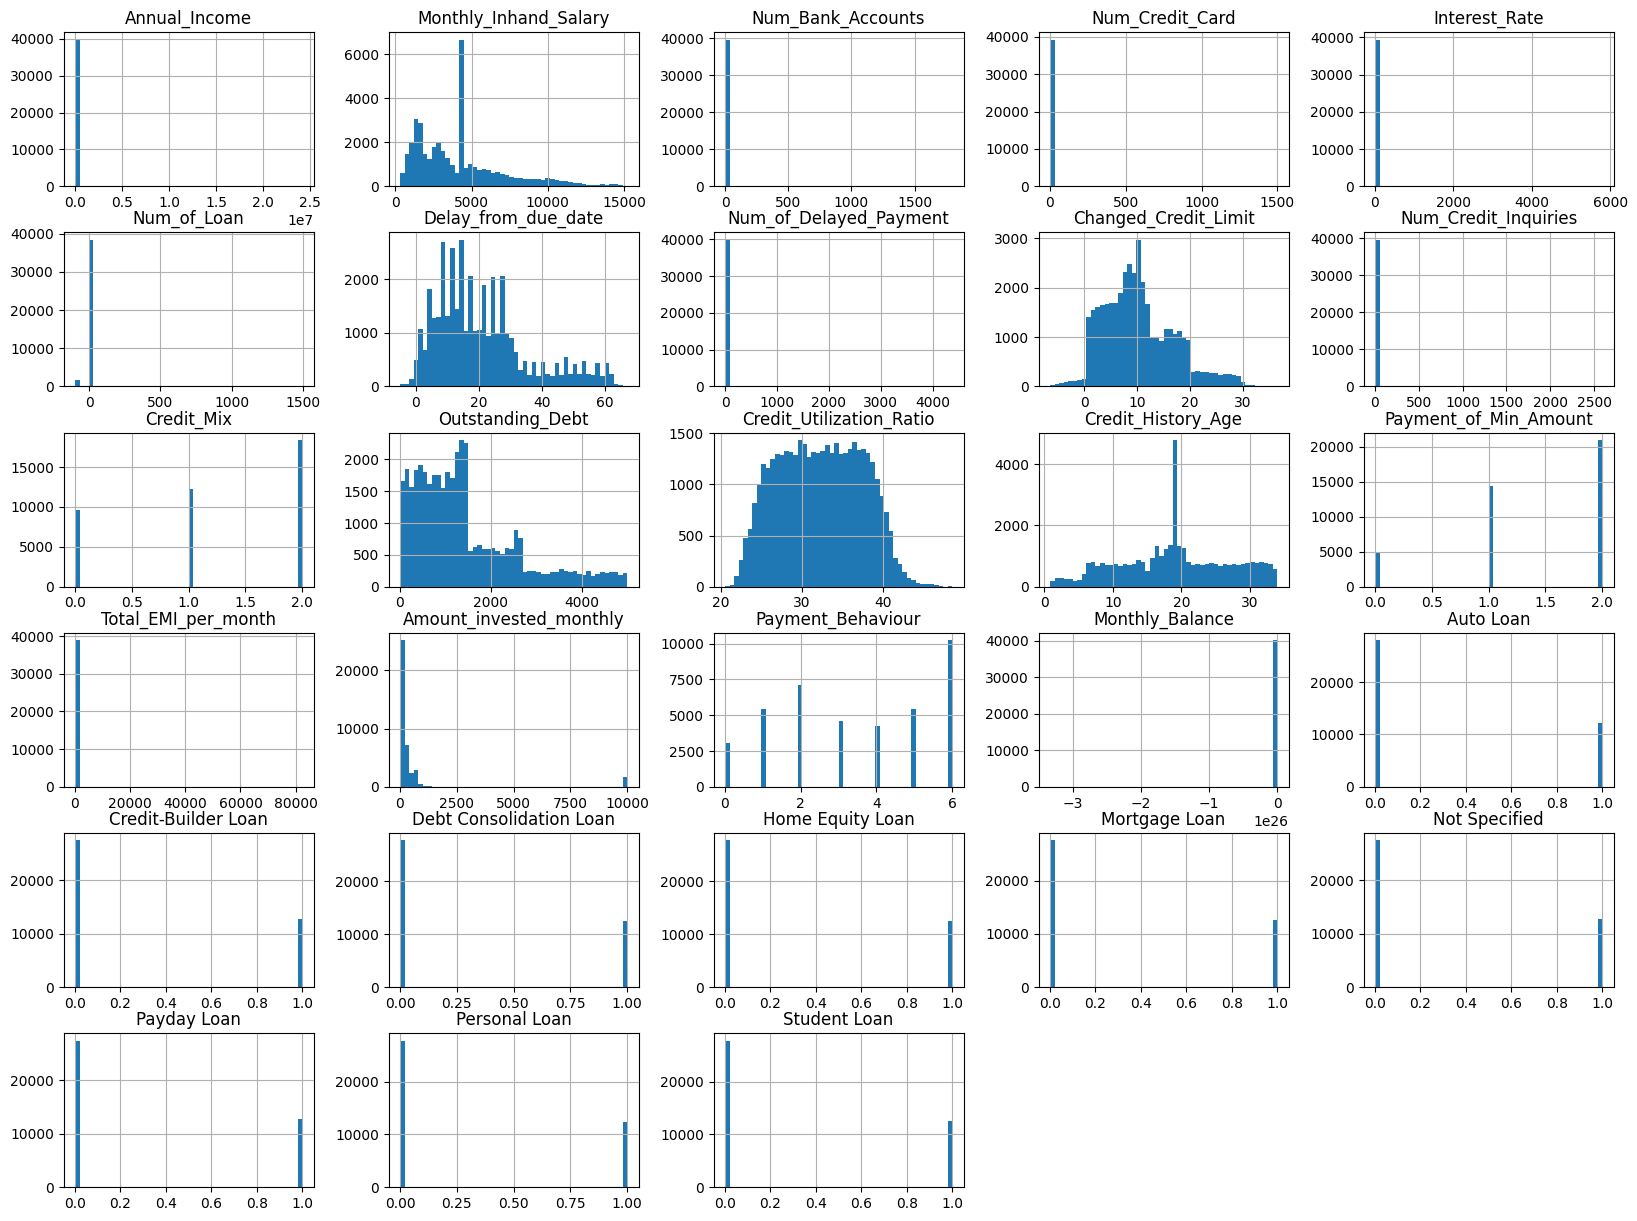

In [58]:
# Histogram
df.hist(bins=50, figsize = [20,15])
plt.show()

<Axes: >

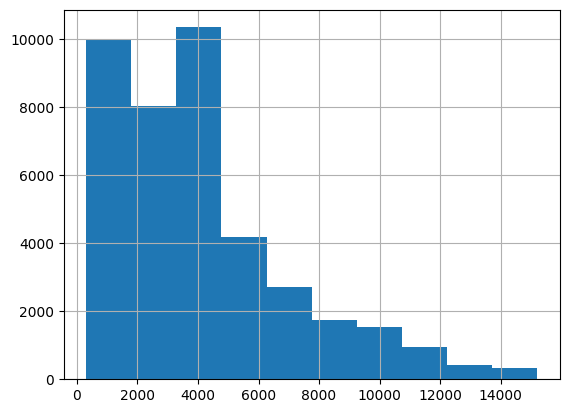

In [59]:
df["Monthly_Inhand_Salary"].hist()

<Axes: >

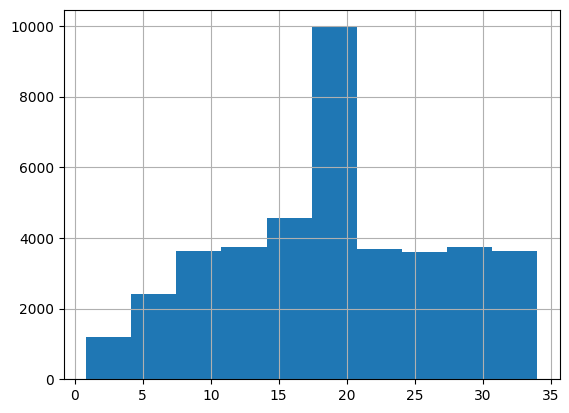

In [60]:
df["Credit_History_Age"].hist()

<Axes: >

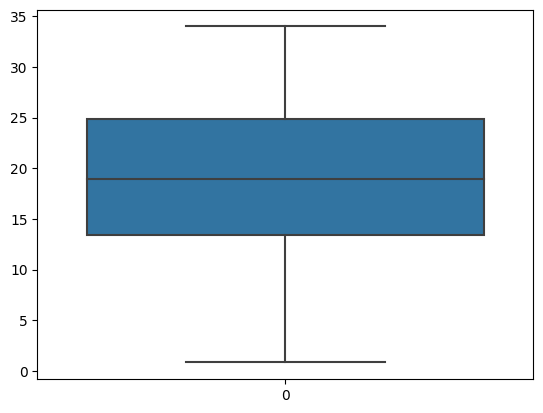

In [61]:
sns.boxplot(df["Credit_History_Age"])

<Axes: >

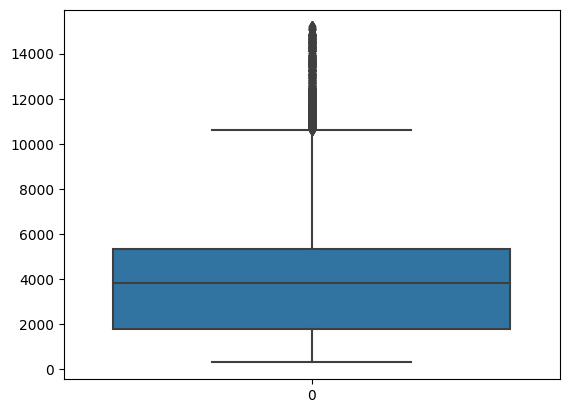

In [62]:
sns.boxplot(df["Monthly_Inhand_Salary"])

<Axes: >

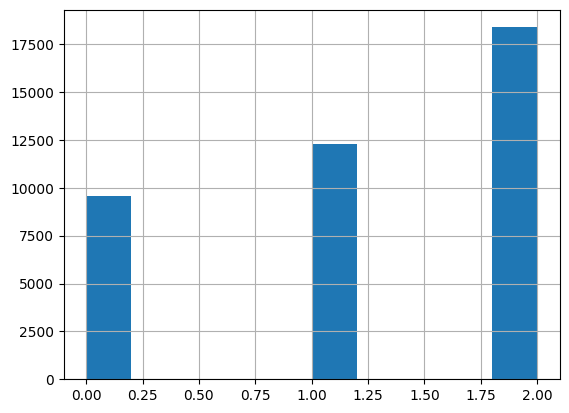

In [63]:
df[df["Credit_Mix"]!= "_"]["Credit_Mix"].hist()

# Data Scaling

In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
scaler = StandardScaler()

In [66]:
for col_name in df.columns:
    if df[col_name].dtypes == "float64":
        df[col_name] = scaler.fit_transform(df[[col_name]])

# Model Training & Evaluation(First Stage)

In [67]:
from sklearn.model_selection import train_test_split

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Support Vector Machine (SVM)
from sklearn.svm import SVC

# Gradient Boosting Classifier (XGBoost)
import xgboost as xgb
from xgboost import XGBClassifier

In [68]:
# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(df.drop("Credit_Mix",axis=1), df["Credit_Mix"], test_size=0.2, random_state=42)


In [69]:
# Initialize models
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC()
xg = XGBClassifier()

In [70]:
## Lr
lr.fit(X_train,y_train)

LogisticRegression()

In [71]:
predicted = lr.predict(X_test)

In [72]:
import sklearn.metrics as mt

In [73]:
print(mt.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1937
           1       0.66      0.71      0.69      2434
           2       0.71      0.67      0.69      3668

    accuracy                           0.72      8039
   macro avg       0.73      0.73      0.73      8039
weighted avg       0.72      0.72      0.72      8039



In [74]:
predicted_train = lr.predict(X_train)

In [75]:
print(mt.classification_report(y_train, predicted_train))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      7619
           1       0.68      0.72      0.70      9826
           2       0.71      0.68      0.70     14711

    accuracy                           0.73     32156
   macro avg       0.73      0.74      0.74     32156
weighted avg       0.73      0.73      0.73     32156



In [76]:
## rf

In [77]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [78]:
predicted = rf.predict(X_test)

In [79]:
print(mt.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1937
           1       0.97      0.98      0.97      2434
           2       0.97      0.96      0.97      3668

    accuracy                           0.97      8039
   macro avg       0.97      0.97      0.97      8039
weighted avg       0.97      0.97      0.97      8039



In [80]:
## SVM

In [81]:
svm.fit(X_train,y_train)

SVC()

In [82]:
predicted = svm.predict(X_test)

In [83]:
print(mt.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1937
           1       0.82      0.79      0.80      2434
           2       0.73      0.81      0.77      3668

    accuracy                           0.78      8039
   macro avg       0.79      0.76      0.78      8039
weighted avg       0.78      0.78      0.78      8039



In [84]:
## XGboost

In [85]:
xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [86]:
predicted = xg.predict(X_test)

In [87]:
print(mt.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1937
           1       0.97      0.97      0.97      2434
           2       0.97      0.97      0.97      3668

    accuracy                           0.97      8039
   macro avg       0.97      0.97      0.97      8039
weighted avg       0.97      0.97      0.97      8039



In [88]:
## Random forest and XG boost performed the best

# Data Finalization

In [89]:
for col_name in df_test.columns:
    if df_test[col_name].dtypes == "float64":
        df_test[col_name] = scaler.fit_transform(df_test[[col_name]])

In [90]:
predicted_credit_mix = rf.predict(df_test.drop("Credit_Mix",axis=1))

In [91]:
predicted_credit_mix

array([1, 1, 1, ..., 1, 0, 1])

In [92]:
df_test.drop("Credit_Mix",axis=1,inplace=True)

In [93]:
df_test['Credit_Mix'] = predicted_credit_mix

In [94]:
df_test.tail(5)

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan,Credit_Mix
49983,-0.088032,0.000506,0,4,6,1,14,-0.149015,-0.788441,-0.007858,...,0,0,0,0,0,1,0,0,0,1
49987,-0.108243,0.000506,1,1,5,4,1,-0.149015,-0.997814,-0.116048,...,0,0,0,0,1,1,1,0,1,1
49991,-0.092437,-0.365054,1,4,5,3,3,-0.086353,-0.746863,-0.140547,...,0,0,0,1,1,0,0,0,1,1
49995,-0.105682,-0.758278,10,8,29,5,33,-0.018470,1.173130,-0.096449,...,1,0,0,0,1,0,0,1,1,0
49999,-0.090556,-0.276643,4,6,7,2,22,-0.122906,0.161904,-0.120948,...,1,0,0,0,0,0,0,0,1,1


In [95]:
df2 = pd.concat([df, df_test])

In [96]:
df2.head(5)

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,-0.109508,-0.808431,3,4,3,4,3,-0.111870,0.134834,10.342615,...,0.010115,1,1,0,1,0,0,0,1,0
1,-0.109508,-0.808431,3,4,3,4,3,-0.102724,0.433253,-0.133358,...,0.010115,1,1,0,1,0,0,0,1,0
2,-0.109508,-0.808431,3,4,3,4,-1,-0.125589,0.284043,-0.133358,...,0.010115,1,1,0,1,0,0,0,1,0
3,-0.109508,-0.000126,3,4,3,4,4,-0.121016,0.134834,-0.133358,...,0.010115,1,1,0,1,0,0,0,1,0
4,-0.097980,-0.392426,2,4,6,1,3,-0.139308,-0.738043,-0.128167,...,0.010115,0,1,0,0,0,0,0,0,0


In [97]:
df2["Credit_Mix"].nunique()

3

# Model Training(2nd Phase)

In [98]:
# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(df2.drop("Credit_Mix",axis=1), df2["Credit_Mix"], test_size=0.2, random_state=42)

In [99]:
lr.fit(X_train,y_train)

LogisticRegression()

In [100]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [101]:
svm.fit(X_train,y_train)

SVC()

In [102]:
xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Model Evaluation

In [103]:
#LR

In [104]:
predicted_lr_train= lr.predict(X_train)

In [105]:
predicted_lr_test= lr.predict(X_test)

In [106]:
print(mt.classification_report(y_train,predicted_lr_train))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      9601
           1       0.71      0.68      0.70     12145
           2       0.70      0.72      0.71     18254

    accuracy                           0.73     40000
   macro avg       0.74      0.74      0.74     40000
weighted avg       0.73      0.73      0.73     40000



In [107]:
print(mt.classification_report(y_test,predicted_lr_test))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2367
           1       0.70      0.70      0.70      3048
           2       0.71      0.72      0.72      4585

    accuracy                           0.74     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.74      0.74      0.74     10000



In [108]:
#RF

In [109]:
predicted_rf_train = rf.predict(X_train)

In [110]:
predicted_rf_test= rf.predict(X_test)

In [111]:
print(mt.classification_report(y_train,predicted_rf_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9601
           1       1.00      1.00      1.00     12145
           2       1.00      1.00      1.00     18254

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



In [112]:
print(mt.classification_report(y_test,predicted_rf_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2367
           1       0.97      0.98      0.97      3048
           2       0.98      0.96      0.97      4585

    accuracy                           0.97     10000
   macro avg       0.97      0.98      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [113]:
#SVM

In [114]:
predicted_svm_train= svm.predict(X_train)

In [115]:
predicted_svm_test= svm.predict(X_test)

In [116]:
print(mt.classification_report(y_train,predicted_svm_train))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      9601
           1       0.84      0.79      0.81     12145
           2       0.75      0.82      0.78     18254

    accuracy                           0.79     40000
   macro avg       0.81      0.78      0.79     40000
weighted avg       0.80      0.79      0.79     40000



In [117]:
print(mt.classification_report(y_test,predicted_svm_test))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      2367
           1       0.82      0.81      0.81      3048
           2       0.75      0.81      0.78      4585

    accuracy                           0.79     10000
   macro avg       0.80      0.78      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [118]:
#XGB

In [119]:
predicted_xg_train= xg.predict(X_train)

In [120]:
predicted_xg_test= xg.predict(X_test)

In [121]:
print(mt.classification_report(y_train,predicted_xg_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9601
           1       1.00      1.00      1.00     12145
           2       1.00      1.00      1.00     18254

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



In [122]:
print(mt.classification_report(y_test,predicted_xg_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2367
           1       0.96      0.98      0.97      3048
           2       0.98      0.96      0.97      4585

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [123]:
# Confusion Matrix

<Axes: >

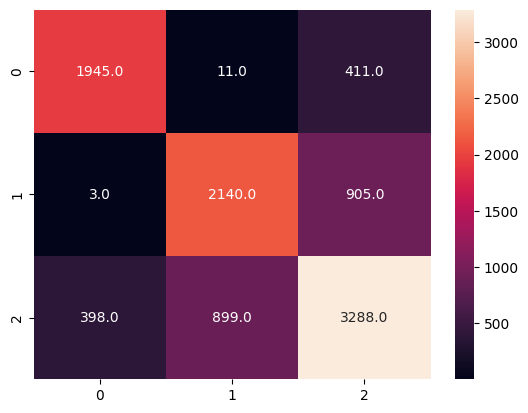

In [124]:
sns.heatmap(mt.confusion_matrix(y_test,predicted_lr_test), annot=True,fmt=".1f")

<Axes: >

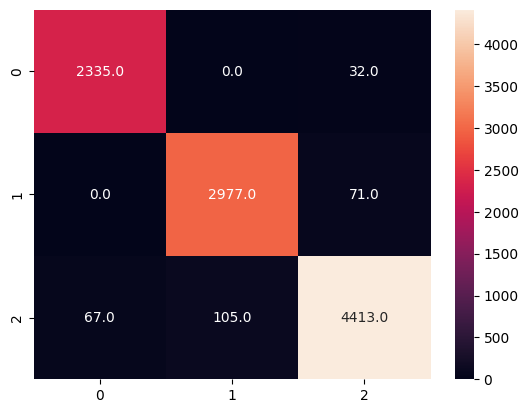

In [125]:
sns.heatmap(mt.confusion_matrix(y_test,predicted_rf_test), annot=True,fmt=".1f")

<Axes: >

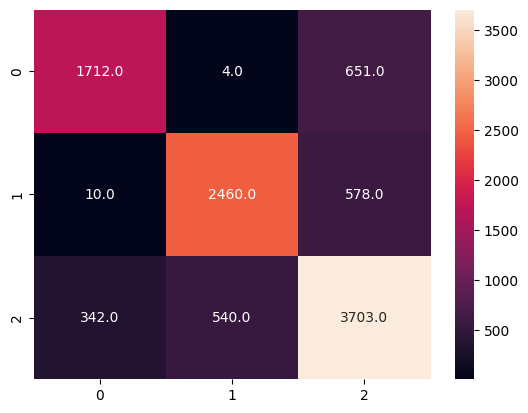

In [126]:
sns.heatmap(mt.confusion_matrix(y_test,predicted_svm_test), annot=True,fmt=".1f")

<Axes: >

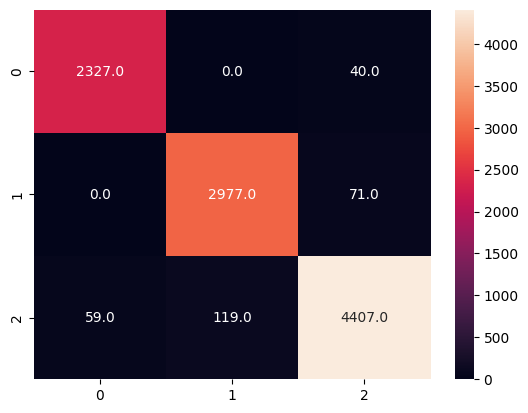

In [127]:
sns.heatmap(mt.confusion_matrix(y_test,predicted_xg_test), annot=True,fmt=".1f")

# Hyperparameter Tuning

In [128]:
from sklearn.model_selection import GridSearchCV

In [129]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}


In [130]:
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [131]:
best_params = grid_search.best_params_

In [132]:
# Retrain XGB

In [133]:
best_xgb_classifier = XGBClassifier(**best_params)

In [134]:
best_xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [135]:
predicted = best_xgb_classifier.predict(X_test)

In [136]:
print(mt.classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2367
           1       0.97      0.99      0.98      3048
           2       0.98      0.97      0.98      4585

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# Conclusion

Both Random Forest Classifier and XGBoostClassifier performs extremely well(around 97% accurracy) with good precision and recall score. We futher tuned the hyperparameters of XGBoost to improve performence.After using Grid Search on some important parameters, our performence increased by 1% which is around 98%. So now our XGBoost model can classify credit scores extremely well.